# Mass balance + Introduction to ModelingToolkit for Julia
## Case 1: Liquid Level in Tanks
### Author: Bernt Lie, University of South-Eastern Norway
### Date: February 7, 2023
## 0. Preamble
### 0.1. Installing packages

In [1]:
using ModelingToolkit
using DifferentialEquations
using Plots, LaTeXStrings
using BenchmarkTools
using Latexify

### 0.2. Constants

In [2]:
# Specifying line properties as constants makes it possible to globally 
# change these values and keep consistency
LW1 = 2.5
LC1 = :red
LC2 = :blue
LC3 = :green

LS1 = :solid 
LS2 = :dash

figpath = "C:/Users/Bernt/OneDrive/Documents/booksBLSOL/ModDynSyst/figs/"
figtype = ".svg"
SAVEFIG = true
;

## 1. Constant area tank without influent
### 1.1. Variables, parameters, and differentiaton operator:

In [3]:
@variables t m(t) ṁ_e(t) V(t) h(t)      # ṁ is created by typing m + \dot + TAB
@parameters ρ A K h_ς
Dt = Differential(t)
;

Here, variables and parameters can either be separated by space, or by comma, i.e., `@variables a b c` and `@variables a,b,c` give the same result.

In [4]:
@variables t, m(t), ṁ_e(t), V(t), h(t)
@parameters ρ, A, K, h_ς
Dt = Differential(t)
;

### 1.2. Naive implementation

In [5]:
eqs_1 = [Dt(m) ~ -ṁ_e,
        m ~ ρ*V,
        V ~ A*h,
        ṁ_e ~ K*sqrt(h/h_ς)]

@named tank = ODESystem(eqs_1)

Model tank with 4 equations
States (4):
  m(t)
  ṁ_e(t)
  V(t)
  h(t)
Parameters (4):
  ρ
  A
  h_ς
  K

Sometimes, it may be needed to specify the independent variable. To do so, use the following syntax - if the independent variable is `t`:
```julia
@named tank = ODESystem(eqs_1,t)
```

### 1.3. Simplification and index reduction
To use ODE solvers, we need to reduce the DAE to a so-called index 1 DAE, which can be written as
$$
M\frac{\mathrm{d}x}{\mathrm{d}t} = f(x,u;t)
$$
where $M$ is a possibly singular matrix and there are some requirements on $f(\cdot)$. As an example, if the structure of $M$ is block diagonal with non-singular $M_1$ in the first diagonal block and $M_2 = 0$ in the second, and we partition $x$ into $x_1, x_2$, we can write the equation as
$$
M_1 \frac{\mathrm{d}x_1}{\mathrm{d}t} = f_1(x_1,x_2,u;t) \\
0 = f_2(x_1,x_2,u;t)
$$
and the system is then a DAE of index 1 if the Jacobian $\partial f_2(x_1,x_2,u;t)/\partial x_2$ is non-singular for all values of $(x_1,x_2,u;t)$.

*NOTE* that if $M$ is a singular matrix, e.g., $M_2$ is zero, i.e., the resulting model is a DAE of index 1, it is necessary to use a solver which supports *mass matrix*, i.e., $M\neq I$. Solvers with support for mass matrix are listed in the documentation for `DifferentialEquations.jl`, under **DAE Solvers** [more precisely, `OrdinaryDiffEq.jl (Mass Matrix)` heading].

On the other hand, if $M$ is *non-singular*, it is always possible to premultiply the model with $M^{-1}$ and rewrite the DAE of index 0 as an ODE, and it is not required to use a solver with mass matrix; then, in principle, all solvers for `DifferentialEquations.jl` under **ODE Solvers** can be used.

 Command `structural_simplify` performs the reduction of the original model to a DAE of index 1, and more: `structural_simplify` removes redundant equations, removes redundant variables and puts them into a class `observed`, and reduces the equations to a DAE of index 1. In order for `structural_simplify` to work, it must be possible to reduce the model to a system where the number of equations and the number of remaining unknowns are equal, i.e., a balanced system.

In [6]:
tank_simp = structural_simplify(tank)

Model tank with 1 equations
States (1):
  m(t)
Parameters (4):
  ρ
  A
  h_ς
  K
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

Note that this simplified model apparently has $m$ as state and $h$ on the right hand side (here, *matrix* $M=1$). Clearly, this is not a complete model - the equation does not show the relationship between $m$ and $h$!
However, the key thing to understand from the above equation is that we (i) need to provide initial value for $m$ (since the equation shows the time derivative of $m$), and (ii) the relationship between $m$ and $h$ is still there, but it is hidden. Requesting the `equations` for the model gives:

In [7]:
equations(tank_simp)

1-element Vector{Equation}:
 Differential(t)(m(t)) ~ -ṁ_e(t)

which is the same as above and does not provide more information. However, command `full_equations` writes the model in state-space form (but still hides some algebraic equations needed to compute the remaining variables):

In [8]:
full_equations(tank_simp)

1-element Vector{Equation}:
 Differential(t)(m(t)) ~ -K*sqrt(m(t) / (A*h_ς*ρ))

### 1.4. States, Observed, and Parameters

We can also inspect *states*, *observed*, and *parameters*.

*States*

**NOTE**: in the ModelingToolkit *lingo*, "state" means *unknown* in the *structurally simplified model*, i.e., it equals $x$ in the simplified index 1 DAE model $M\frac{\mathrm{d}x}{\mathrm{d}t} = f(x,u;t)$.

In [9]:
states(tank_simp)

1-element Vector{Any}:
 m(t)

*Observed*

When going from the original model formulation with its defined *variables*, doing `structural_simplify` removes some of these variables because they are not needed in the reduced index 1 DAE. These *removed* variables are denoted **observed**. The *observed* variables are not involved when finally solving the model numerically, but ModelingToolkit still needs to keep track of them so that they can be plotted, etc. 

To this end, let $x$ be the "states" in the index 1 DAE simplified model, and let $\omega$ be the *observed* variables. `structural_simplify` then removes $\omega$ from the model, but will still keep track of how $\omega$ can be computed as $\omega = g(\omega,x,u)$ (where the $\omega$ dependence in $g(\cdot)$ is such that $\omega$ can be easily computed, e.g., $\omega_1 = g_1(x,u)$, $\omega_2 = g_2(\omega_1,x,u)$, etc.). The unknowns in the union of $x$ and $\omega$ will provide the solution to all variables in the *original* model, i.e., before structural simplification.

In [10]:
observed(tank_simp)

3-element Vector{Equation}:
 V(t) ~ m(t) / ρ
 h(t) ~ V(t) / A
 ṁ_e(t) ~ K*sqrt(h(t) / h_ς)

In [11]:
parameters(tank_simp)

4-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 ρ
 A
 h_ς
 K

Note that the concept of "state" in ModelingToolkit may be different from the way "state" is defined in traditional dynamic systems literature, but here the interpretations coinside.

In general, ModelingToolkit refers to the unknowns (after structural simplification?) as states. The remaining unknowns are computed by some hidden algebraic relations, and are referred to as *observables* or *observed variables*.

### 1.5. Converting symbolic model to numeric model

So far, we have operated with a symbolic model (instantiated by function `ODESystem`). We now are ready to create a *numeric implementation* of the model using function `ODEProblem`, where we also need to specify initial state, time span for the simulation, and provide numeric values for parameters.

To solve the numeric implementation of the model (instantiated by `ODEProblem`), we use method `solve`, with the name of the problem as argument. Here, we could also specify which numeric solver to use, accuracy, etc., but we will use default values initially.


In [12]:
x0 = [m => 1.5*ρ*A] # Specifying initial state(s)
tspan = (0.0,3.8)   # Specifying tuple of initial and final time -- must be floating point
par = [ρ => 1, A => 5, K => 5, h_ς => 3]    # Parameters

prob = ODEProblem(tank_simp, x0, tspan, par)
;

**OBSERVE**: It is possible to specify initial states via parameter values. It is, in fact, also possible to express parameter values via other parameter values.

### 1.6. Providing *default* values in model
Above, we have provided values for initial state `x0` and parameters `par` as arguments in the constructor `ODEProblem` for the numeric implementation.

We could *alternatively* have given the parameters and variables *default* values in the original symbolic model. There are two ways to do this:

**Alternative 1**:

In [13]:
@variables t m(t)=1.5*ρ*A ṁ_e(t) V(t) h(t)      # ṁ is created by typing m + \dot + TAB
@parameters ρ=1 A=5 K=5 h_ς=3
Dt = Differential(t)

eqs_1 = [Dt(m) ~ -ṁ_e,
        m ~ ρ*V,
        V ~ A*h,
        ṁ_e ~ K*sqrt(h/h_ς)]

@named tank = ODESystem(eqs_1)
tank_simp = structural_simplify(tank)

Model tank with 1 equations
States (1):
  m(t) [defaults to 1.5A*ρ]
Parameters (4):
  ρ [defaults to 1]
  A [defaults to 5]
  h_ς [defaults to 3]
  K [defaults to 5]
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

**NOTE**: When providing default values as above (`A=5`, etc.), the parameters must be listed as a *tuple*, i.e., `@parameters (ρ=1, A=5, K=5, h_ς=3)`. This is also the case for *variables.

**NEXT**: We can now use the constructor `ODEProblem` without providing initial values for the "states" (because it is a positional argument, we need to set an empty bracket `[]`) and without providing values for the parameters (parameters are also positional arguments, but we don't need to provide an empty bracket `[]` because it is the last of the positional arguments...)

In [14]:
prob = ODEProblem(tank_simp, [], tspan)
;

If we decide that we don't *like* the default values, we can still override them in constructing the numeric model:

In [15]:
prob = ODEProblem(tank_simp, [m => 1.7*ρ*A], tspan, [A=>7])
;

**Finally**: observe that when giving default values for parameters and "states", we do not have to provide default values for all parameters and (initial values for all) states. But the combination of specified default values and the actual values provided in the constructor `ODEProblem` must specify all parameters and initial values for all "states".

**Alternative 2**:
We can alternatively provide defaults by assigning a *dictionary* to keyword argument `defaults` of the symbolic constructor `ODESystem`. 

In [16]:
@variables t m(t) ṁ_e(t) V(t) h(t)
@parameters ρ A K h_ς
Dt = Differential(t)

eqs_1 = [Dt(m) ~ -ṁ_e,
        m ~ ρ*V,
        V ~ A*h,
        ṁ_e ~ K*sqrt(h/h_ς)]

@named tank = ODESystem(eqs_1; defaults = Dict(ρ=>1, A=>5, K=>5, h_ς=>3, m=>1.5*ρ*A))
tank_simp = structural_simplify(tank)

Model tank with 1 equations
States (1):
  m(t) [defaults to 1.5A*ρ]
Parameters (4):
  ρ [defaults to 1]
  A [defaults to 5]
  h_ς [defaults to 3]
  K [defaults to 5]
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

Obviously, default values can be overridden for Alternative 2 just as for Alternative 1.

### 1.7. Numerical *solution* of the model
Solving the numeric *problem* formulation `prob` is done via function `solve`, which comes from the `DifferentialEquations.jl` package.

In [17]:
sol = solve(prob);

Function `solve` allows one to specify the numeric solver as the *second* positional argument of the `solve` function. If you want to specify solver, `Tsit5()` is one possibility. If the simplified model has a mass matrix $M$, it is required to use DAE solver which supports mass matrices, e.g., `QBDF()`.

The call would then be, e.g.,
```julia
sol = solve(prob, Tsit5())
```
It is also possible to add a number of keyword assignments to the `solve` function. Some relevant keyword assignments are `reltol` (relative tolerance), `abstol` (absolute tolerance), `saveat` (the time interval between when solutions should be saved), etc.

Example:
```julia
sol = solve(prob; reltol=1e-3)
```

### 1.8. Numerical quality of model
If the simulation time is too long, the level may become negative due to numeric error. Then the solver takes the square root of a negative number, and crashes due to the resulting complex value. This happens with end time between 3.8 and 3.9 seconds.

In [18]:
x0 = [m => 1.5*ρ*A] # Specifying initial state(s)
tspan = (0.0,3.8)   # Specifying tuple of initial and final time.
par = [ρ => 1, A => 5, K => 5, h_ς => 3]    # Parameters

prob = ODEProblem(tank_simp, x0, tspan, par)

sol = solve(prob);

### 1.9. Crude plotting of solution

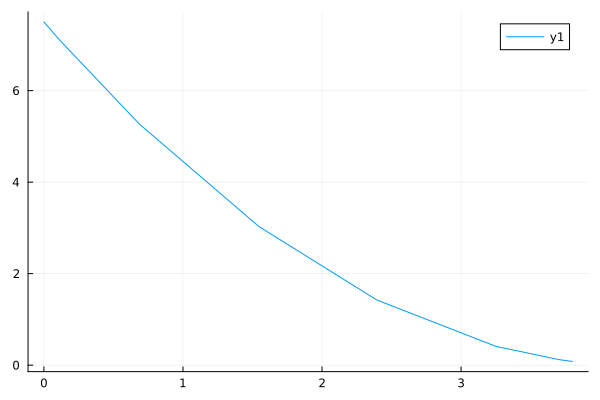

In [19]:
plot(sol[t],sol[m])

Note the jagged quality of the plot. The reason is that `plot`draws straight lines between the points given by `sol[t]` and `sol[m]`; we have only a few values of each pair `sol[t]` and `sol[m]`:

In [20]:
length(sol[t])

8

### 1.10. Smooth plotting of solution

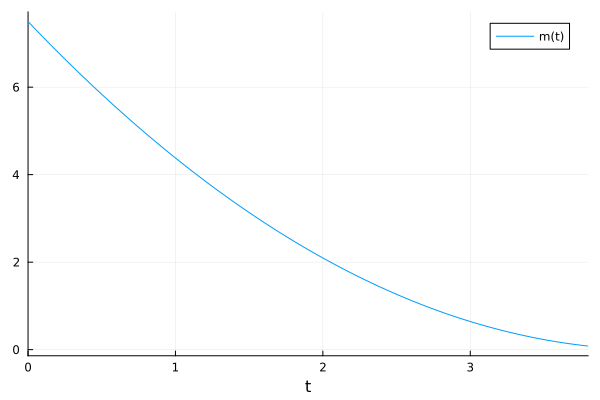

In [21]:
plot(sol)

Note the smooth quality of the plot. The reason is that `plot` here uses the *interpolation* function embedded in the solution object `sol`, and can therefore compute values for $m$ for many more time instances $t$ than the few values in $sol.t$. [Also note that `plot`adds an xlabel (`t`) and a label for the plot `m(t)`].

Let us refine the plot slightly, and plot level `h` instead of mass `m`.

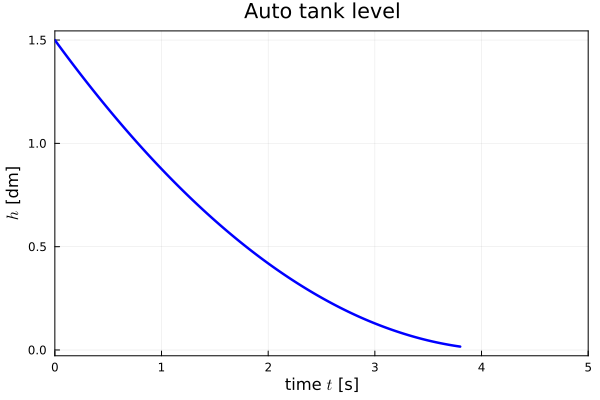

In [22]:
plot(sol, idxs = [h], xlabel="",lc=LC2,lw=LW1,label="")
plot!(title="Auto tank level", xlabel=L"time $t$ [s]",ylabel=L"$h$ [dm]",xlims=(0,5))
plot!(framestyle =:box, grid=true)

In [23]:
if SAVEFIG
    figname = "autoTankSim-1"
    savefig(figpath*figname*figtype)
end
;

We could also manually use the interpolation function as follows (to illustrate that we can interpolate in many more points than the `length(sol.t)` = 19 points when plotting the vectors of the solution).

Let us first check the result of interpolating over a sequence of numbers:

In [24]:
sol.(0:0.5:3)

7-element Vector{Vector{Float64}}:
 [7.5]
 [5.836399378505207]
 [4.3811215918217465]
 [3.1342013737081835]
 [2.0955551406376474]
 [1.2652130233314103]
 [0.6432173337131979]

The result is a *vector of vectors*, but we need a simple vector of scalars. To convert the above result to the needed form, a relatively simple and efficient method is the following:

In [25]:
reduce(vcat, sol.(0:0.5:3))

7-element Vector{Float64}:
 7.5
 5.836399378505207
 4.3811215918217465
 3.1342013737081835
 2.0955551406376474
 1.2652130233314103
 0.6432173337131979

Now we can do the plotting, now also with some refinements:

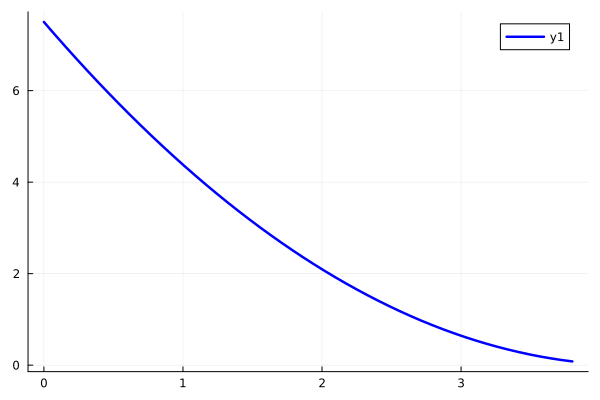

In [26]:
tm = range(0,3.8,length=50)
plot(tm,reduce(vcat,sol.(tm)),lw=LW1,lc=LC2)

Again, note the smooth quality of the plot. Also, since we selected the data points manually by manual interpolation, `plot`has not added labels.

### 1.11. Robustified model implementation
The absolute value of the level is taken inside of the square root, to avoid generation of a complex number. We also include the sign function of level + the max value to make sure that the effluent flow rate is not allowed to *enter* the tank.

In [27]:
eqs_2 = [Dt(m) ~ -ṁ_e,
        m ~ ρ*V,
        V ~ A*h,
        ṁ_e ~ max(K*sign(h)*sqrt(abs(h/h_ς)),0)]

@named tank = ODESystem(eqs_2)

Model tank with 4 equations
States (4):
  m(t)
  ṁ_e(t)
  V(t)
  h(t)
Parameters (4):
  ρ
  A
  h_ς
  K

In [28]:
tank_simp = structural_simplify(tank)

Model tank with 1 equations
States (1):
  m(t)
Parameters (4):
  ρ
  A
  h_ς
  K
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

In [29]:
x0 = [m => 1.5*ρ*A] # Initial state
tspan = (0,5)   # Time span. For ModelingToolkit models, the time span can be a tuple of integers
par = [ρ => 1, A => 5, K => 5, h_ς => 3]    # Parameters

prob = ODEProblem(tank_simp, x0, tspan, par)

sol = solve(prob);

### 1.12. Understanding the solution `sol`
The solution object `sol` is dual-faced: It is a vector of solutions of the state at given time points, just like in other computing tools:

In [30]:
sol.t'   # Alternatively: sol[t]; transpose is taken to save vertical space

1×19 adjoint(::Vector{Float64}) with eltype Float64:
 0.0  0.116234  0.686968  1.54617  2.39379  …  4.24579  4.25608  4.35897  5.0

In [31]:
sol[m]'

1×19 adjoint(::Vector{Float64}) with eltype Float64:
 7.5  7.09468  5.26784  3.02957  1.42429  …  -5.55509e-7  -5.55509e-7

NOTE: if we want to find the time point of the *other* variables, i.e., those which are not states, we simply do as follows:

In [32]:
sol[ṁ_e]'

1×19 adjoint(::Vector{Float64}) with eltype Float64:
 3.53553  3.43867  2.96306  2.24706  …  0.00640682  0.0  0.0  0.0  0.0

The way this works is that ModelingToolkit keeps track of equations for how these non-state variables = *observed* variables relate to the states, which have actually be computed. Then the solution of these observed variables are computed from these equations.

One more example:

In [33]:
sol[h]'

1×19 adjoint(::Vector{Float64}) with eltype Float64:
 1.5  1.41894  1.05357  0.605914  0.284859  …  -1.11102e-7  -1.11102e-7

**NOTE THAT** `sol` in *addition* contains interpolations of the solution, which serves two purposes: (i) plotting the solution as an interpolation gives considerably smoother plots, and (ii) we can interpolate and compute the solution at other time instances than those provide by `sol.t`:

In [34]:
sol(0.5)

1-element Vector{Float64}:
 5.836399378505207

Observe that `sol(0.5)` provides the *state* (here: $m$) at time $t=0.5$.

Suppose that we instead want an interpolated value of *observed* variables? This can be done as follows:

In [35]:
sol(0.5; idxs = ṁ_e)

3.1188671497049496

In [36]:
sol(0.5; idxs = [ṁ_e, h])

2-element Vector{Float64}:
 3.1188671497049496
 1.1672798757010414

### 1.13. Simulation results
First, we plot simply the level:

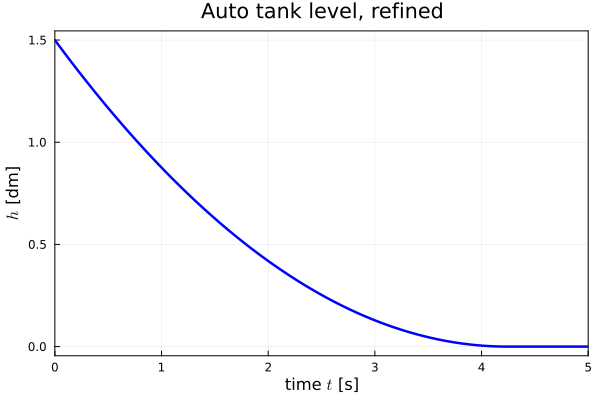

In [37]:
plot(sol, idxs = [h], xlabel="",lc=LC2,lw=LW1,label="")
plot!(title="Auto tank level, refined", xlabel=L"time $t$ [s]",ylabel=L"$h$ [dm]")
plot!(framestyle =:box, grid=true)

In [38]:
if SAVEFIG
    figname = "autoTankSim-2"
    savefig(figpath*figname*figtype)
end
;

Let us make a slightly more advanced plot.

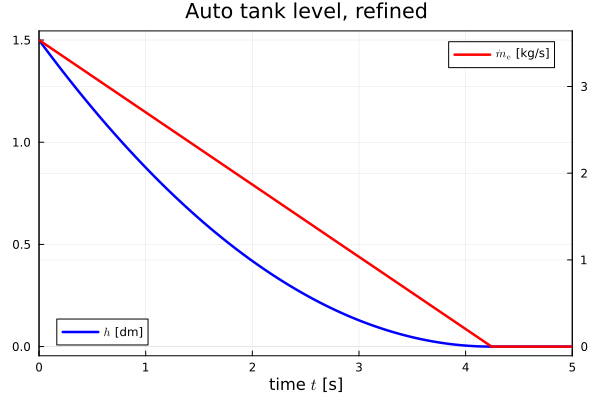

In [39]:
plot(sol, idxs = [h], xlabel="",lc=LC2,lw=LW1,label = L"$h$ [dm]", legend=:bottomleft)
plot!(title="Auto tank level, refined", xlabel=L"time $t$ [s]")
plot!(twinx(),sol,idxs = [ṁ_e], lc=LC1,lw=LW1,xlabel="",label = L"$\dot{m}_\mathrm{e}$ [kg/s]")
plot!(framestyle =:box, grid=true)

Here, we have created a plot with twin ordinate axes ("y-axes"). Labels are located close to the axis that is relevant for the particular variable, i.e., the left hand side ordinate axis (range: 0-1.5) is valid for the level $h$, while the right hand side ordinate axis (range: 0-3) is valid for the effluent $\dot{m}_\mathrm{e}$.

## 2. Constant area tank with influent
When the model has an influent, it will not become empty, so there is little chance of the level $h$ to become negative by numerical error. Because of this, we can now use the simple expression for effluent.

We will use two input functions: one with constant value of 2, `ṁ_const(t)`, and one which starts at value 2 and then jumps down to value 1.5 at time = 1, `ṁ_step(t)`. The actual influent function is denoted `ṁ(t)`, and we set `ṁ(t)` equal to one of `ṁ_const(t)` and `ṁ_step(t)`.

In [40]:
ṁ_const(t) = 2
ṁ_step(t) = t < 1 ? 2 : 1.5    # meaning: if t < 1, then 2, else 1.5
;

### 2.1. Constant influent
We create a function `ṁ(t)`which equals `ṁ_const(t)`:

In [41]:
ṁ(t) = ṁ_const(t);

Because function `ṁ(t)` is unknown to `ModelingToolkit.jl`, it must be *registered* (standard built-in Julia functions are by default registered) before we can use it:

In [42]:
@register_symbolic ṁ(t)

We now create the model with influent `ṁ_i` which we will set equal to function `ṁ`:

In [43]:
@variables ṁ_i(t)

eqs_3 = [Dt(m) ~ ṁ_i-ṁ_e,
        m ~ ρ*V,
        V ~ A*h,
        ṁ_e ~ K*sqrt(h/h_ς),
        ṁ_i ~ ṁ(t)]

@named tank = ODESystem(eqs_3)

Model tank with 5 equations
States (5):
  m(t)
  ṁ_e(t)
  ṁ_i(t)
  V(t)
⋮
Parameters (4):
  ρ
  A
  h_ς
  K

In [44]:
tank_simp = structural_simplify(tank)

x0 = [m => 1.5*ρ*A] # Initial state
tspan = (0,15)   # Time span
par = [ρ => 1, A => 5, K => 5, h_ς => 3]    # Parameters: a vector of assignments of type symbol => value

prob = ODEProblem(tank_simp, x0, tspan, par)

sol = solve(prob);

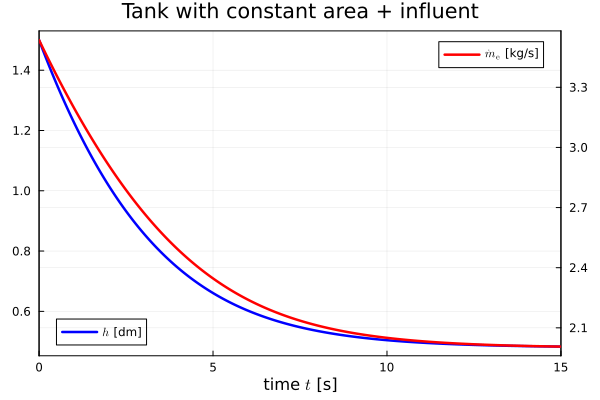

In [45]:
plot(sol, idxs = [h], xlabel="",lc=LC2,lw=LW1,label = L"$h$ [dm]", legend=:bottomleft)
plot!(title="Tank with constant area + influent", xlabel=L"time $t$ [s]")
plot!(twinx(),sol,idxs = [ṁ_e], lc=LC1,lw=LW1,xlabel="",label = L"$\dot{m}_\mathrm{e}$ [kg/s]")
plot!(framestyle =:box, grid=true)

### 2.2. Time varying influent
Next, we consider a time-varying influent starting at `ṁ_i = 2`, and changing to `ṁ_i = 1.5` at `t = 1`. For this case, we will also start the simulation in steady state. 

First we create a plot with $m$ from the previous simulation with constant input.

In [46]:
fg_const_input = plot(sol, idxs = [h], xlabel="",lc=LC1,lw=LW1,label = L"$h$ [dm]")
fg_const_input_copy = plot(sol, idxs = [h], xlabel="",lc=LC1,lw=LW1,label = L"$h$ [dm]")
;

Next, we want to simulate the model with input `ṁ_i ~2` until it reaches steady state in order to find the steady state value of `m`; we assume steady state has been reached at `t = 100`.

In [47]:
x0 = [m => 1.5*ρ*A] # Initial state
tspan = (0,100)   # Time span
par = [ρ => 1, A => 5, K => 5, h_ς => 3]    # Parameters

prob = ODEProblem(tank_simp, x0, tspan, par)

sol = solve(prob)
m_ss = sol[end][1];  # Because sol[end] is a vector, we need to append [1] to pick out the scalar value

Next, we *change* function `ṁ(t)` to give a step change:

In [48]:
ṁ(t) = ṁ_step(t);

Then we create a numeric model with initial state `m_ss`:

In [49]:
x0 = [m => m_ss] # Initial state
tspan = (0,15)   # Time span
par = [ρ => 1, A => 5, K => 5, h_ς => 3]    # Parameters

prob = ODEProblem(tank_simp, x0, tspan, par)
                            
sol = solve(prob);

We can now append the new plots to the previous plot with a constant input:

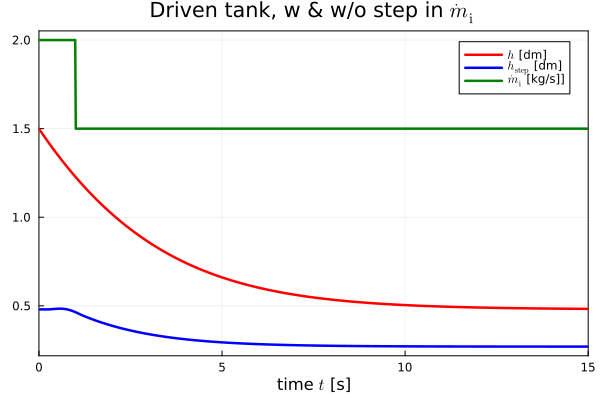

In [50]:
plot!(fg_const_input,sol, idxs = [h], xlabel="",lc=LC2,lw=LW1,label = L"$h_\mathrm{step}$ [dm]")
plot!(sol, idxs = [ṁ_i], xlabel="",lc=LC3,lw=LW1,label = L"$\dot{m}_\mathrm{i}$ [kg/s]]")
plot!(title=L"Driven tank, w & w/o step in $\dot{m}_\mathrm{i}$", xlabel=L"time $t$ [s]")
plot!(framestyle =:box, grid=true)

In [51]:
if SAVEFIG
    figname = "drivenTankSim"
    savefig(figpath*figname*figtype)
end
;

Note that there is a slight "overshoot" in the solution of $h_\mathrm{step}$ in the figure above. This is not realistic, and we could have improved on the result by specifying a better solver than the default one, and/or specified absolute and relative tolerances for the solver. 

### 2.3. Handling inputs in a smarter way
The implementation workflow we have used so far works well. *HOWEVER*, when we later will want to consider linearization of models, there is a better way to do it.

Note that when we formulate a *symbolic model* (prior to structural simplification), there is no problem with this model being incomplete, i.e., with having more variables (unknowns) than equations. In order to do linearization (later), the model that we linearize *must* have fewer equations than unknowns -- in fact, we can not (in general) have equations for the inputs.

When we do `structural_simplify`, however, the model that we structural simplification of *must* be balances = have the same number of equations and unknowns.

This means that, in general, we must have one version of the model that we can do linearization of, and a model extended with input specifications that we do structural simplification of. This is somewhat unfortunate, so we need to do the modeling in a way that minimizes this problem. [NOTE: there is a way around this by introcuding so-called `analysis points`, but that requires more knowledge of ModelingToolkit than we need by now.]

So let us define one model without specifying the inputs, and one model where we specify the inputs. Then we extend the model without inputs with the input specifications.

In [52]:
@parameters ρ=1 A=5 K=5 h_ς=3
@variables t m(t)=1.5*ρ*A ṁ_i(t) ṁ_e(t) V(t) h(t)
Dt = Differential(t)

eqs_b = [Dt(m) ~ ṁ_i-ṁ_e,
        m ~ ρ*V,
        V ~ A*h,
        ṁ_e ~ K*sqrt(h/h_ς)]

@named tank_b = ODESystem(eqs_b)    # Basic tank model, i.e., without inputs

Model tank_b with 4 equations
States (5):
  m(t) [defaults to 1.5A*ρ]
  ṁ_e(t)
  ṁ_i(t)
  V(t)
⋮
Parameters (4):
  ρ [defaults to 1]
  A [defaults to 5]
  h_ς [defaults to 3]
  K [defaults to 5]

Observe that model `tank_b` has 5 unknowns and 4 equations, i.e., it is not balanced.

In [53]:
eqs_i = [ṁ_i ~ ṁ(t)]
@named tank_i = ODESystem(eqs_i)    # Model of inputs to the tank

Model tank_i with 1 equations
States (1):
  ṁ_i(t)
Parameters (0):

In [54]:
tank = extend(tank_i, tank_b)

Model tank_i with 5 equations
States (5):
  m(t) [defaults to 1.5A*ρ]
  ṁ_e(t)
  ṁ_i(t)
  V(t)
⋮
Parameters (4):
  ρ [defaults to 1]
  A [defaults to 5]
  h_ς [defaults to 3]
  K [defaults to 5]

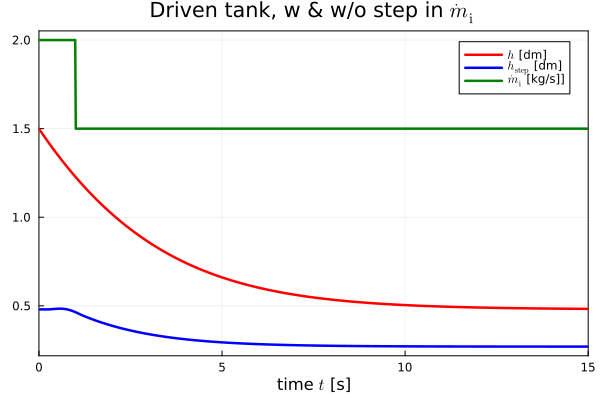

In [55]:
tank_simp = structural_simplify(tank)
prob = ODEProblem(tank_simp, [m=>m_ss], tspan)
sol = solve(prob)

plot(fg_const_input_copy)
plot!(sol, idxs = [h], xlabel="",lc=LC2,lw=LW1,label = L"$h_\mathrm{step}$ [dm]")
plot!(sol, idxs = [ṁ_i], xlabel="",lc=LC3,lw=LW1,label = L"$\dot{m}_\mathrm{i}$ [kg/s]]")
plot!(title=L"Driven tank, w & w/o step in $\dot{m}_\mathrm{i}$", xlabel=L"time $t$ [s]")
plot!(framestyle =:box, grid=true)


## 3. Varying area tank with input

In [56]:
@parameters ρ=1 R_ς=sqrt(15/π) K=5 h_ς=3
@variables t h(t)=1.5 ṁ_i(t) ṁ_e(t) r(t) Ar(t)

ṁ(t) = ṁ_const(t)

eqs_b = [Dt(h) ~ (ṁ_i-ṁ_e)/(ρ*Ar),
        Ar ~ Num(π)*r^2,
        r ~ R_ς/h_ς*h,
        ṁ_e ~ K*sqrt(h/h_ς)]

@named tank_b = ODESystem(eqs_b)

eqs_i = [ṁ_i ~ ṁ(t)]
@named tank_i = ODESystem(eqs_i)

tank = extend(tank_i, tank_b)

Model tank_i with 5 equations
States (5):
  h(t) [defaults to 1.5]
  ṁ_e(t)
  ṁ_i(t)
  Ar(t)
⋮
Parameters (4):
  ρ [defaults to 1]
  R_ς [defaults to 2.1851]
  h_ς [defaults to 3]
  K [defaults to 5]

In [57]:
tank_simp = structural_simplify(tank)

tspan = (0,15)   # Time span

prob = ODEProblem(tank_simp, [], tspan)

sol = solve(prob);

In [58]:
plot(sol, idxs = [h], xlabel="",lc=LC1,lw=LW1,label = L"$h$ [dm]");

We simulate the system for 100 s to find steady state level `h_ss`:

In [59]:
tspan = (0,100)   # Time span

prob = ODEProblem(tank_simp, [], tspan)

sol = solve(prob)
h_ss = sol[end][1]; # Because sol[end] is a vector, we need to append [1] to pick out the scalar value

Next, we *change* function `ṁ(t)` to give a step change:

In [60]:
ṁ(t) = ṁ_step(t);

Then we create a numeric model with initial state `h_ss`. This time, the initial state is "relatively" close to zero, so some numerical error may cause the level to become negative and cause a crash of the solver. 

To alleviate this, we specify the solver (`Tsit5()`) to the `solve` function, as well as specifies relative and absolute tolerance for the solver.

In [61]:
x0 = [h => h_ss] # Initial state
tspan = (0,15)   # Time span

prob = ODEProblem(tank_simp, x0, tspan)

sol = solve(prob, Tsit5();reltol=1e-8,abstol=1e-8);

We can now append the new plots to the previous plot with a constant input:

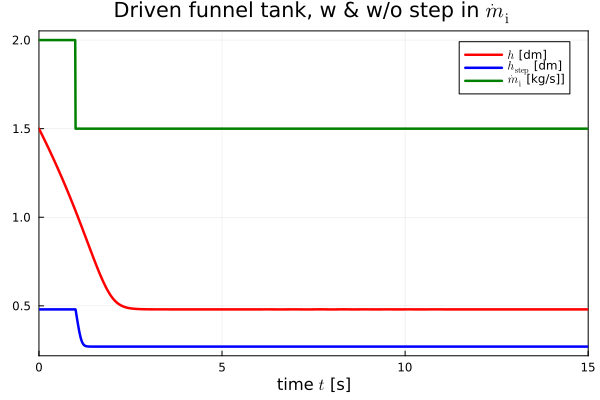

In [62]:
plot!(sol, idxs = [h], xlabel="",lc=LC2,lw=LW1,label = L"$h_\mathrm{step}$ [dm]")
plot!(sol, idxs = [ṁ_i], xlabel="",lc=LC3,lw=LW1,label = L"$\dot{m}_\mathrm{i}$ [kg/s]]")
plot!(title=L"Driven funnel tank, w & w/o step in $\dot{m}_\mathrm{i}$", xlabel=L"time $t$ [s]")
plot!(framestyle =:box, grid=true)

In [63]:
if SAVEFIG
    figname = "drivenFunnelTankSim"
    savefig(figpath*figname*figtype)
end
;

## 4. Appendix: Fine-tuning model implementation
### 4.1. Structure of variables and parameters
It is of interest to understand the structure of what is produced when creating parameters and variables. As we will see, it is also possible to add arguments to the `ODESystem` constructor.

First, the structure of definitions of `@variables` and `@parameters`.

In [64]:
@parameters ρ A K

3-element Vector{Num}:
 ρ
 A
 K

In [65]:
@parameters h_ς

1-element Vector{Num}:
 h_ς

As we see, the result is a *vector*. Sometimes, we want to have a vector of *all* parameters, and be able to *refer* to the parameter vector by name. We can do this as follows:

In [66]:
pars1 = @parameters ρ A K

3-element Vector{Num}:
 ρ
 A
 K

In [67]:
pars2 = @parameters h_ς

1-element Vector{Num}:
 h_ς

In [68]:
pars = [pars1; pars2]

4-element Vector{Num}:
   ρ
   A
   K
 h_ς

However, this is somewhat cumbersome. Instead, we can do as follows:

In [69]:
pars = @parameters ρ A K h_ς

4-element Vector{Num}:
   ρ
   A
   K
 h_ς

...or as:

In [70]:
pars = @parameters (ρ, A, K, h_ς)

4-element Vector{Num}:
   ρ
   A
   K
 h_ς

The latter construct is advantageous, because it (i) allows us to add default values and the consctruct still works, and (ii) we can spread the definition of parameters over several lines:

In [71]:
pars = @parameters(ρ=1, A=5, K=5,
                   h_ς=3)

4-element Vector{Num}:
   ρ
   A
   K
 h_ς

Finally, it is adviceable to make a separation between the *independent variable* (normallly time $t$ in this course), and the dependent variables. Thus, the following structure would be adviceable.

In [72]:
# Independent variables
@variables t 
# Differential operator
Dt = Differential(t)
# Parameters
pars = @parameters (ρ=1, A=5, K=5, h_ς=3)
# Dependent variables 
vars = @variables (m(t)=1.5*ρ*A, ṁ_e(t), V(t), h(t))
;

### 4.2. Fields of `struct` created by constructor `ODESystem`
Constructor `ODESystem` creates a data structure with certain fields. From the documentation of `ODESystem`, the structure holds a number of fields. Some of the most basic fields are:

`name`: Name: the name of the system.

`eqs`: The ODEs defining the system.

`iv`: Independent variable.

`ps`: Parameter variables. Must not contain the independent variable.

`states`: Dependent (state) variables. Must not contain the independent variable.

`observed`: Observed states.

`defaults`: defaults: The default values to use when initial conditions and/or parameters are not supplied in ODEProblem.

`metadata`: metadata: metadata for the system, to be used by downstream packages.

Let us check out some of these fields.

In [73]:
eqs = [Dt(m) ~ -ṁ_e,
        m ~ ρ*V,
        V ~ A*h,
        ṁ_e ~ max(K*sign(h)*sqrt(abs(h/h_ς)),0)]

@named tank = ODESystem(eqs)

tank_simp = structural_simplify(tank)

Model tank with 1 equations
States (1):
  m(t) [defaults to 1.5A*ρ]
Parameters (4):
  ρ [defaults to 1]
  A [defaults to 5]
  h_ς [defaults to 3]
  K [defaults to 5]
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

In [74]:
tank.name, tank_simp.name

(:tank, :tank)

In [75]:
tank_simp.eqs

Equation[Differential(t)(m(t)) ~ -ṁ_e(t)][1:1]

In [76]:
tank_simp.iv

t

In [77]:
tank_simp.ps

SymbolicUtils.BasicSymbolic{Real}[ρ, A, h_ς, K][1:4]

In [78]:
tank_simp.states

Any[m(t)][1:1]

In [79]:
tank_simp.observed

Equation[V(t) ~ m(t) / ρ, h(t) ~ V(t) / A, ṁ_e(t) ~ max(K*sign(h(t))*sqrt(abs(h(t) / h_ς)), 0)][1:3]

In [80]:
tank_simp.defaults

Dict{Any, Any} with 5 entries:
  h_ς  => 3
  K    => 5
  m(t) => 1.5A*ρ
  A    => 5
  ρ    => 1

In [81]:
tank_simp.metadata

We have previously seen functions such as `equations`, `states`, `observed`, etc. These are simply functions that read the field values (as above), and present them in a nicer way.

In addition to the functions `equations`, `states`, and `observed`, there is a function `defaults` - but this one is not *exported* by default, and needs to be called as `ModelingToolkit.defaults()`.

In [82]:
ModelingToolkit.defaults(tank_simp)

Dict{Any, Any} with 5 entries:
  h_ς  => 3
  K    => 5
  m(t) => 1.5A*ρ
  A    => 5
  ρ    => 1

Because we have not defined *meta data*, the field `metadata` is empty.

### 4.3. Call signature of `ODESystem` constructor
We have seen that we can construct an `ODESystem` by `ODESystem(eqs)`. It is, however, possible to use other call signatures, e.g., `ODESystem(eqs, independent_variable, variables, parameters)`. When we use the simplified version `ODESystem(eqs)` these additional variables are given default values.

However, at times, the constructor may get confused by our model/equations when we use a single input argument. Providing additional arguments will help the constructor to create a correct model.

To illustrate this, assume the following "academic" example:

In [83]:
@variables t 
Dt = Differential(t)
pars = @parameters (a=10, b=a/10, c=a/20)
vars = @variables (x(t) = 1, z(t))

eqs = [ Dt(x) ~ -b*(x-z),
    0 ~ z + c*x]

2-element Vector{Equation}:
 Differential(t)(x(t)) ~ -b*(x(t) - z(t))
 0 ~ c*x(t) + z(t)

In [84]:
@named sys = ODESystem(eqs)
sys_simp = structural_simplify(sys)

Model sys with 1 equations
States (1):
  x(t) [defaults to 1]
Parameters (2):
  b [defaults to (1//10)*a]
  c [defaults to (1//20)*a]
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

In [85]:
states(sys_simp)

1-element Vector{Any}:
 x(t)

In [86]:
observed(sys_simp)

1-element Vector{Equation}:
 z(t) ~ -c*x(t)

In [87]:
ModelingToolkit.defaults(sys_simp)

Dict{Any, Any} with 3 entries:
  x(t) => 1
  b    => (1//10)*a
  c    => (1//20)*a

**Observe** that parameter `a` which has a default value, does not show up *explicitly* in the equations, and that `b` and `c` are defined *via* `a`. This has a consequence when we create a numeric version of the model...

In [88]:
tspan = (0,3)

prob = ODEProblem(sys_simp, [], tspan)

MethodError: MethodError: no method matching AbstractFloat(::Type{SymbolicUtils.BasicSymbolic{Real}})

Closest candidates are:
  (::Type{T})(!Matched::SymbolicUtils.Symbolic) where T<:Union{AbstractFloat, Integer, Complex{<:AbstractFloat}, Complex{<:Integer}}
   @ Symbolics C:\Users\Bernt\.julia\packages\Symbolics\CNA2l\src\Symbolics.jl:146
  (::Type{T})(!Matched::AbstractChar) where T<:Union{AbstractChar, Number}
   @ Base char.jl:50
  (::Type{T})(!Matched::Base.TwicePrecision) where T<:Number
   @ Base twiceprecision.jl:266
  ...


What happens if we instead use the `ODESystem` constructor with 4 inputs?

In [89]:
@named sys1 = ODESystem(eqs, t, vars, pars)

Model sys1 with 2 equations
States (2):
  x(t) [defaults to 1]
  z(t)
Parameters (3):
  a [defaults to 10]
  b [defaults to (1//10)*a]
  c [defaults to (1//20)*a]

In [90]:
sys1_simp = structural_simplify(sys1)

Model sys1 with 1 equations
States (1):
  x(t) [defaults to 1]
Parameters (3):
  a [defaults to 10]
  b [defaults to (1//10)*a]
  c [defaults to (1//20)*a]
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

In [91]:
ModelingToolkit.defaults(sys1_simp)

Dict{Any, Any} with 4 entries:
  a    => 10
  x(t) => 1
  b    => (1//10)*a
  c    => (1//20)*a

We see that this time, the symbolic function is aware of all parameters (including `a`), and has given values to them. The reason is that this time, we have *explicitly* provided the vector of parameters to the constructor, while if we only provide the *equations*, the constructor parses the equations to find parameters... and parameter `a` is missing from the equations.

Let us try to solve the model based on the 4-input constructor:

In [92]:
prob = ODEProblem(sys1_simp, [], tspan)

ODEProblem with uType Vector{Float64} and tType Int64. In-place: true
timespan: (0, 3)
u0: 1-element Vector{Float64}:
 1.0

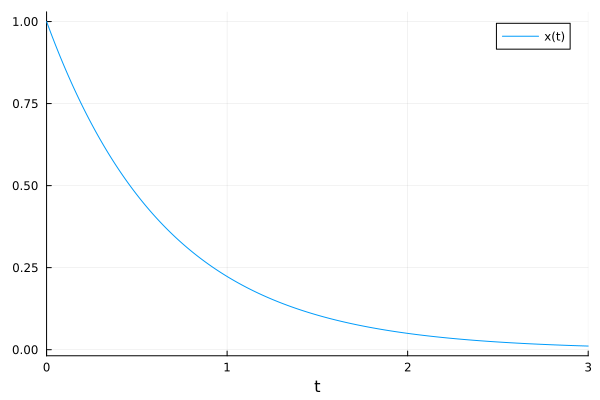

In [93]:
sol = solve(prob)

plot(sol)

## 5. Appendix: Resusable model
### 5.1. Previous model formulation

In [94]:
# Independent variables
@variables t 
# Differential operator
Dt = Differential(t)
# Parameters
pars = @parameters (ρ=1, A=5, K=5, h_ς=3)
# Dependent variables 
vars = @variables (m(t)=1.5*ρ*A, ṁ_e(t), V(t), h(t))
;

In [95]:
eqs = [Dt(m) ~ -ṁ_e,
        m ~ ρ*V,
        V ~ A*h,
        ṁ_e ~ max(K*sign(h)*sqrt(abs(h/h_ς)),0)]

@named tank1 = ODESystem(eqs,t,vars,pars)

tank1_simp = structural_simplify(tank1)

Model tank1 with 1 equations
States (1):
  m(t) [defaults to 1.5A*ρ]
Parameters (4):
  ρ [defaults to 1]
  A [defaults to 5]
  K [defaults to 5]
  h_ς [defaults to 3]
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

In [96]:
tspan = (0,5)

prob1 = ODEProblem(tank1_simp, [], tspan)

ODEProblem with uType Vector{Float64} and tType Int64. In-place: true
timespan: (0, 5)
u0: 1-element Vector{Float64}:
 7.5

### 5.2. Model constructor
Instead of creating the model as above, we can create a constructor for a model which can be reused. This involves packaging the model into a function, and a model can then be constructed by calling this constructor.

In [97]:
# Generic tank model
function tank_model(; name)
    # Independent variables
    @variables t 
    # Differential operator
    Dt = Differential(t)
    # Parameters
    pars = @parameters (ρ=1, A=5, K=5, h_ς=3)
    # Dependent variables 
    vars = @variables (m(t)=1.5*ρ*A, ṁ_e(t), V(t), h(t))
    #
    eqs = [Dt(m) ~ -ṁ_e,
        m ~ ρ*V,
        V ~ A*h,
        ṁ_e ~ max(K*sign(h)*sqrt(abs(h/h_ς)),0)]

    ODESystem(eqs, t, vars, pars; name)
    #
end
;

In [98]:
@named tank2 = tank_model()
tank2_simp = structural_simplify(tank2)

Model tank2 with 1 equations
States (1):
  m(t) [defaults to 1.5A*ρ]
Parameters (4):
  ρ [defaults to 1]
  A [defaults to 5]
  K [defaults to 5]
  h_ς [defaults to 3]
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

In [99]:
prob2 = ODEProblem(tank2_simp, [], tspan)

ODEProblem with uType Vector{Float64} and tType Int64. In-place: true
timespan: (0, 5)
u0: 1-element Vector{Float64}:
 7.5

### 5.3. Comparing execution time
*Original* model formulation

In [100]:
@btime solve(prob1);

  24.000 μs (277 allocations: 29.73 KiB)


*Constructor* model formulation

In [101]:
@btime solve(prob2);

  19.500 μs (277 allocations: 29.73 KiB)


**Learning**: execution time is more or less the same for the original formulation and the model created using the model constructor. The same goes for the memory allocation.

### 5.4. Simulation results
These should be identical...

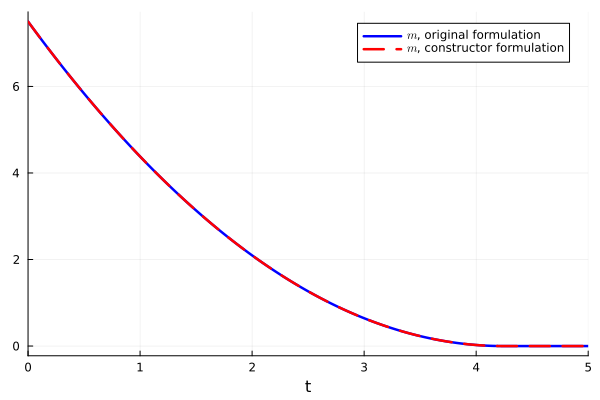

In [102]:
sol1 = solve(prob1)
sol2 = solve(prob2)
#
plot(sol1, lw=LW1, ls=LS1, lc=LC2,label=L"$m$, original formulation")
plot!(sol2, lw=LW1, ls=LS2, lc=LC1,label=L"$m$, constructor formulation")